            [0. 1. 0. 1.]  --  bus  --  2024-02-08 18:42:33.815821
    [0.83 0.48 1.   1.17]  --  bus  --  2024-02-08 18:42:34.815821
    [1.45 0.51 2.14 1.29]  --  bus  --  2024-02-08 18:42:35.815821
    [2.13 0.91 3.64 1.47]  --  bus  --  2024-02-08 18:42:36.815821
    [3.01 0.92 5.49 2.23]  --  bus  --  2024-02-08 18:42:37.815821
    [3.59 0.5  8.07 2.44]  --  bus  --  2024-02-08 18:42:38.815821
[ 3.81  0.24 10.52  2.27]  --  bus  --  2024-02-08 18:42:39.815821
[ 3.93  0.11 12.78  2.25]  --  bus  --  2024-02-08 18:42:40.815821
[ 4.23  0.32 15.04  2.1 ]  --  bus  --  2024-02-08 18:42:41.815821
[4.480e+00 1.000e-02 1.708e+01 2.020e+00]  --  bus  --  2024-02-08 18:42:42.815821
[ 4.41 -0.21 18.88  1.84]  --  bus  --  2024-02-08 18:42:43.815821


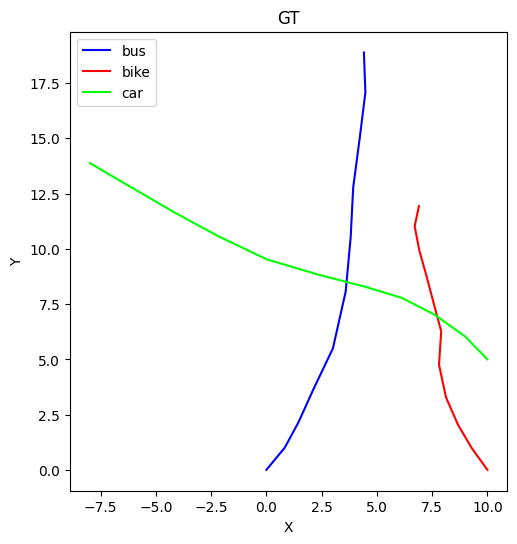

In [1]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np

from stonesoup.models.transition.linear import ConstantVelocity, \
    CombinedLinearGaussianTransitionModel
from stonesoup.types.groundtruth import GroundTruthState

start = datetime.now()

kinematic_state1 = GroundTruthState([0, 1, 0, 1], timestamp=start)  # x, vx, y, vy
kinematic_state2 = GroundTruthState([10, -1, 0, 1], timestamp=start)
kinematic_state3 = GroundTruthState([10, -1, 5, 1], timestamp=start)

kinematic_transition = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.1),
                                                              ConstantVelocity(0.1)])

from stonesoup.types.groundtruth import CategoricalGroundTruthState
from stonesoup.models.transition.categorical import MarkovianTransitionModel

hidden_classes = ['bike', 'car', 'bus']
gt_kwargs = {'timestamp': start, 'categories': hidden_classes}
category_state1 = CategoricalGroundTruthState([0, 0, 1], **gt_kwargs)
category_state2 = CategoricalGroundTruthState([1, 0, 0], **gt_kwargs)
category_state3 = CategoricalGroundTruthState([0, 1, 0], **gt_kwargs)

category_transition = MarkovianTransitionModel(transition_matrix=np.eye(3))

from stonesoup.types.groundtruth import CompositeGroundTruthState

initial_state1 = CompositeGroundTruthState([kinematic_state1, category_state1])
initial_state2 = CompositeGroundTruthState([kinematic_state2, category_state2])
initial_state3 = CompositeGroundTruthState([kinematic_state3, category_state3])

from stonesoup.types.groundtruth import GroundTruthPath

GT1 = GroundTruthPath([initial_state1], id='GT1')
GT2 = GroundTruthPath([initial_state2], id='GT2')
GT3 = GroundTruthPath([initial_state3], id='GT3')
ground_truth_paths = [GT1, GT2, GT3]

for GT in ground_truth_paths:
    for i in range(10):
        kinematic_sv = kinematic_transition.function(GT[-1][0],
                                                     noise=True,
                                                     time_interval=timedelta(seconds=1))
        kinematic = GroundTruthState(kinematic_sv,
                                     timestamp=GT[-1].timestamp + timedelta(seconds=1))

        category_sv = category_transition.function(GT[-1][1],
                                                   noise=True,
                                                   time_interval=timedelta(seconds=1))
        category = CategoricalGroundTruthState(category_sv,
                                               timestamp=GT[-1].timestamp + timedelta(seconds=1),
                                               categories=hidden_classes)

        GT.append(CompositeGroundTruthState([kinematic, category]))

# Printing GT1
for state in GT1:
    vector = np.round(state[0].state_vector.flatten().astype(np.double), 2)
    print("%25s" % vector, ' -- ', state[1].category, ' -- ', state.timestamp)
    
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(wspace=5)
fig.tight_layout()

for ax in axes:
    ax.set_aspect('equal', 'box')

for GT in ground_truth_paths:
    X = list()
    Y = list()
    col = list(GT[0][1].state_vector)
    for state in GT:
        pos = state[0].state_vector
        X.append(pos[0])
        Y.append(pos[2])
    axes[0].plot(X, Y, color=col, label=GT[-1][1].category)
axes[0].legend(loc='upper left')
axes[0].set(title='GT', xlabel='X', ylabel='Y')
axes[1].set_visible(False)
axes[2].set_visible(False)


def set_axes_limits():
    xmax = max(ax.get_xlim()[1] for ax in axes)
    ymax = max(ax.get_ylim()[1] for ax in axes)
    xmin = min(ax.get_xlim()[0] for ax in axes)
    ymin = min(ax.get_ylim()[0] for ax in axes)
    for ax in axes:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)


set_axes_limits()

In [3]:
from typing import Set, Union, Sequence

from stonesoup.base import Property
from stonesoup.sensor.sensor import Sensor
from stonesoup.types.detection import CompositeDetection


class CompositeSensor(Sensor):
    sensors: Sequence[Sensor] = Property(doc="A list of sensors.")
    mapping: Sequence = Property(default=None,
                                 doc="Mapping of which component states in the composite truth "
                                     "state is measured.")

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        if self.mapping is None:
            self.mapping = list(np.arange(len(self.sensors)))

    def measure(self, ground_truths: Set[CompositeGroundTruthState],
                noise: Sequence[Union[np.ndarray, bool]] = True,
                **kwargs) -> Set[CompositeDetection]:

        if isinstance(noise, bool) or len(noise) == 1:
            noise = len(self.sensors) * [noise]

        detections = set()
        for truth in ground_truths:

            sub_detections = list()

            states = [truth.sub_states[i] for i in self.mapping]

            for state, sub_sensor, sub_noise in zip(states, self.sensors, noise):
                sub_detection = sub_sensor.measure(
                    ground_truths={state},
                    noise=sub_noise
                ).pop()  # sub-sensor returns a set
                sub_detections.append(sub_detection)

            detection = CompositeDetection(sub_states=sub_detections,
                                           groundtruth_path=truth,
                                           mapping=self.mapping)
            detections.add(detection)

        return detections

    @property
    def measurement_model(self):
        raise NotImplementedError
        
from stonesoup.sensor.radar.radar import RadarBearingRange

radar = RadarBearingRange(ndim_state=4,
                          position_mapping=[0, 2],
                          noise_covar=np.diag([np.radians(0.05), 0.1]))

from stonesoup.models.measurement.categorical import MarkovianMeasurementModel
from stonesoup.sensor.categorical import HMMSensor

E = np.array([[0.99, 0.5, 0.01],  # P(small | bike), P(small | car), P(small | bus
              [0.01, 0.5, 0.99]])
model = MarkovianMeasurementModel(emission_matrix=E,
                                  measurement_categories=['small', 'large'])

eo = HMMSensor(measurement_model=model)

sensor = CompositeSensor(sensors=[eo, radar], mapping=[1, 0])

all_measurements = list()

for gts1, gts2, gts3 in zip(GT1, GT2, GT3):
    measurements_at_time = sensor.measure({gts1, gts2, gts3})
    timestamp = gts1.timestamp
    all_measurements.append((timestamp, measurements_at_time))

# Printing some measurements
for i, (time, measurements_at_time) in enumerate(all_measurements):
    if i > 2:
        break
    print(f"{time:%H:%M:%S}")
    for measurement in measurements_at_time:
        vector = np.round(measurement.state_vector.flatten().astype(np.double), 2)
        print("%25s" % vector, ' -- ', measurement[0].category)

18:42:33
[ 0.    1.   -0.01  0.33]  --  large
[ 0.    1.    0.49 11.22]  --  large
[ 1.    0.    0.02 10.18]  --  small
18:42:34
    [0.   1.   0.86 0.91]  --  large
[ 1.    0.    0.6  10.88]  --  small
    [1.   0.   0.06 9.13]  --  small
18:42:35
[ 1.    0.    0.74 10.83]  --  small
    [1.   0.   0.19 9.28]  --  small
    [0.   1.   1.01 2.66]  --  large


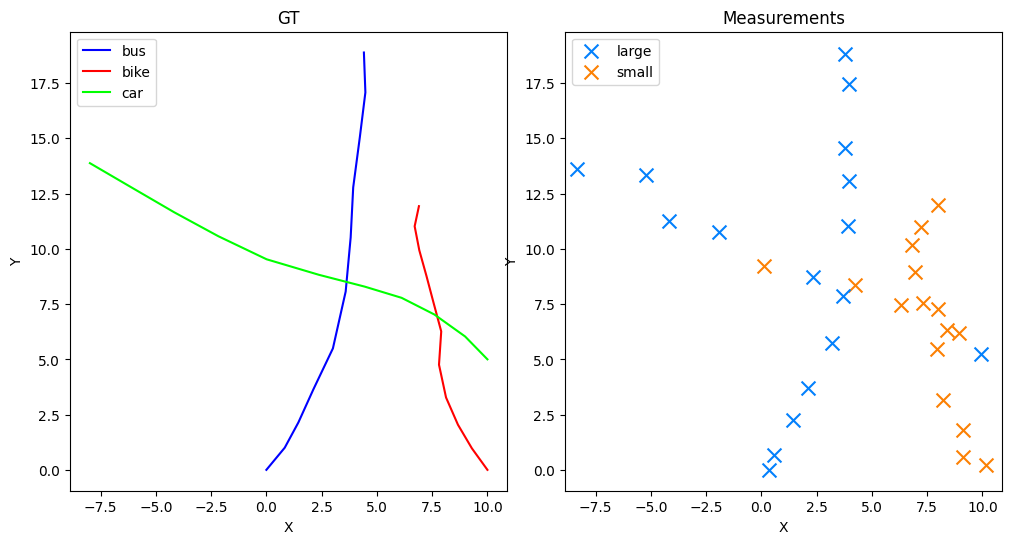

In [4]:
for time, measurements in all_measurements:
    for measurement in measurements:
        loc = measurement[1].state_vector
        obs = measurement[0].state_vector
        col = list(measurement[0].measurement_model.emission_matrix.T @ obs)

        phi = loc[0]
        rho = loc[1]
        x = rho * np.cos(phi)
        y = rho * np.sin(phi)
        axes[1].scatter(x, y, color=col, marker='x', s=100, label=measurement[0].category)

a = axes[1].get_legend_handles_labels()
b = {l: h for h, l in zip(*a)}
c = [*zip(*b.items())]
d = c[::-1]
axes[1].legend(*d, loc='upper left')

axes[1].set(title='Measurements', xlabel='X', ylabel='Y')
axes[1].set_visible(True)
set_axes_limits()
fig

In [5]:
from stonesoup.predictor.kalman import KalmanPredictor
from stonesoup.predictor.categorical import HMMPredictor
from stonesoup.predictor.composite import CompositePredictor

kinematic_predictor = KalmanPredictor(kinematic_transition)
category_predictor = HMMPredictor(category_transition)

predictor = CompositePredictor([kinematic_predictor, category_predictor])

In [6]:
from stonesoup.updater.kalman import ExtendedKalmanUpdater
from stonesoup.updater.categorical import HMMUpdater
from stonesoup.updater.composite import CompositeUpdater

kinematic_updater = ExtendedKalmanUpdater()
category_updater = HMMUpdater()

updater = CompositeUpdater(sub_updaters=[kinematic_updater, category_updater])

In [7]:
from stonesoup.measures import Mahalanobis
from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.types.hypothesis import SingleProbabilityHypothesis
from stonesoup.types.multihypothesis import MultipleHypothesis


class ProbabilityHypothesiser(DistanceHypothesiser):
    def hypothesise(self, track, detections, timestamp, **kwargs):
        multi_hypothesis = super().hypothesise(track, detections, timestamp, **kwargs)
        single_hypotheses = multi_hypothesis.single_hypotheses
        prob_single_hypotheses = list()
        for hypothesis in single_hypotheses:
            prob_hypothesis = SingleProbabilityHypothesis(hypothesis.prediction,
                                                          hypothesis.measurement,
                                                          1 / hypothesis.distance,
                                                          hypothesis.measurement_prediction)
            prob_single_hypotheses.append(prob_hypothesis)
        return MultipleHypothesis(prob_single_hypotheses, normalise=False, total_weight=1)


kinematic_hypothesiser = ProbabilityHypothesiser(predictor=kinematic_predictor,
                                                 updater=kinematic_updater,
                                                 measure=Mahalanobis())

In [8]:
from stonesoup.hypothesiser.categorical import HMMHypothesiser
from stonesoup.hypothesiser.composite import CompositeHypothesiser

category_hypothesiser = HMMHypothesiser(predictor=category_predictor,
                                        updater=category_updater)
hypothesiser = CompositeHypothesiser(
    sub_hypothesisers=[kinematic_hypothesiser, category_hypothesiser]
)

In [10]:
from stonesoup.dataassociator.neighbour import GNNWith2DAssignment

data_associator = GNNWith2DAssignment(hypothesiser)

from stonesoup.types.state import GaussianState, CategoricalState, CompositeState

kinematic_prior = GaussianState([0, 0, 0, 0], np.diag([10, 10, 10, 10]))
category_prior = CategoricalState([1 / 3, 1 / 3, 1 / 3], categories=hidden_classes)
prior = CompositeState([kinematic_prior, category_prior])

Number of tracks 3
id: e9e6b365-59dc-4dcb-9827-ffe17cdf4fb4
    [9.92 0.   5.25 0.  ]  --  bus  --  2024-02-08 18:42:33.815821
[ 9.01 -0.9   6.24  0.98]  --  car  --  2024-02-08 18:42:34.815821
[ 8.02 -0.96  7.28  1.02]  --  car  --  2024-02-08 18:42:35.815821
[ 6.47 -1.34  7.63  0.6 ]  --  car  --  2024-02-08 18:42:36.815821
[ 4.43 -1.79  8.4   0.7 ]  --  car  --  2024-02-08 18:42:37.815821
[ 2.4  -1.95  8.81  0.52]  --  car  --  2024-02-08 18:42:38.815821
[ 0.17 -2.14  9.23  0.46]  --  car  --  2024-02-08 18:42:39.815821
[-1.94 -2.13 10.5   0.98]  --  car  --  2024-02-08 18:42:40.815821
[-4.15 -2.18 11.32  0.88]  --  car  --  2024-02-08 18:42:41.815821
[-5.66 -1.77 13.02  1.41]  --  car  --  2024-02-08 18:42:42.815821
[-8.02 -2.11 13.91  1.09]  --  car  --  2024-02-08 18:42:43.815821
id: 210bc078-1363-46b4-b172-06af39e5c0ba
[ 0.33  0.   -0.    0.  ]  --  bus  --  2024-02-08 18:42:33.815821
    [0.9  0.56 0.28 0.29]  --  bus  --  2024-02-08 18:42:34.815821
    [1.56 0.63 1.65 1.63]  -

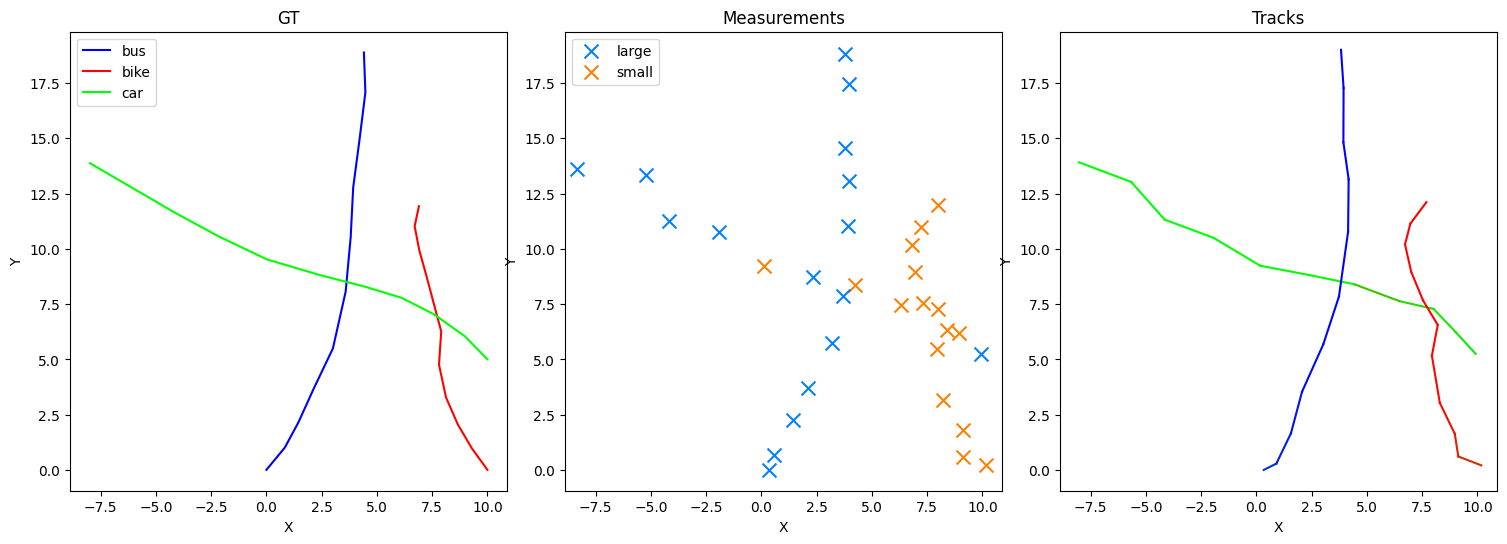

In [13]:
from stonesoup.initiator.simple import SimpleMeasurementInitiator
from stonesoup.initiator.categorical import SimpleCategoricalMeasurementInitiator
from stonesoup.initiator.composite import CompositeUpdateInitiator

kinematic_initiator = SimpleMeasurementInitiator(prior_state=kinematic_prior,
                                                 measurement_model=None)
category_initiator = SimpleCategoricalMeasurementInitiator(prior_state=category_prior,
                                                           updater=category_updater)
initiator = CompositeUpdateInitiator(sub_initiators=[kinematic_initiator, category_initiator])

from stonesoup.deleter.time import UpdateTimeStepsDeleter

deleter = UpdateTimeStepsDeleter(2)

from stonesoup.tracker.simple import MultiTargetTracker

tracker = MultiTargetTracker(initiator, deleter, all_measurements, data_associator, updater)

tracks = set()
for time, ctracks in tracker:
    tracks.update(ctracks)

print(f'Number of tracks {len(tracks)}')
for track in tracks:
    print(f'id: {track.id}')
    for state in track:
        vector = np.round(state[0].state_vector.flatten().astype(np.double), 2)
        print("%25s" % vector, ' -- ', state[1].category, ' -- ', state.timestamp)
        
for track in tracks:
    for i, state in enumerate(track[1:], 1):
        loc0 = track[i - 1][0].state_vector.flatten()
        loc1 = state[0].state_vector.flatten()
        X = [loc0[0], loc1[0]]
        Y = [loc0[2], loc1[2]]
        axes[2].plot(X, Y, label='track', color=list(state[1].state_vector))

axes[2].set(title='Tracks', xlabel='X', ylabel='Y')
axes[2].set_visible(True)
set_axes_limits()
fig